In [13]:
########################################################################################################################
# Imports
########################################################################################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from tqdm import tqdm, tqdm_notebook
import imageio
import cv2

from keras.models import load_model
from keras import backend as K

import keras.models as models
from keras.models import Model

########################################################################################################################
# Import Function definitions
########################################################################################################################
from ShipSegFunctions import *

In [4]:
########################################################################################################################
# GPU info
########################################################################################################################import tensorflow as tf
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto(device_count = {'GPU': 0}) # Use CPU for the testing
config = tf.ConfigProto() # Use GPU
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))
# Device check
# print(device_lib.list_local_devices())
# print(K.tensorflow_backend._get_available_gpus())


In [5]:
########################################################################################################################
# PARAMETERS
########################################################################################################################
# Data on AWS
# image_path = "/data/train_v2"
# segmentation_data_file_path = '/data/train_ship_segmentations_v2.csv'
model_path = ""
# Data locally
image_path = "/run/media/kalap/Storage/Deep learning 2/train_v2"
segmentation_data_file_path = '/run/media/kalap/Storage/Deep learning 2/train_ship_segmentations_v2.csv'
# Data on Github
# image_path = "../data/train_img"
# segmentation_data_file_path = '../data/train_ship_segmentations_v2.csv'

valid_split = 0.15
test_split = 0.15

# resize_img_to = (768, 768)
# resize_img_to = (384, 384)
# resize_img_to = (256, 256)
resize_img_to = (192, 192)
batch_size = 16

In [6]:
########################################################################################################################
# Load and prepare the data
########################################################################################################################

# Load the file which contains the masks for each image
df_train = pd.read_csv(segmentation_data_file_path)

# Load the test data ids saved by the Train file
test_img_ids = np.load(model_path + "test_img_ids.npy")

#######################################################################################################################
# Load the network
########################################################################################################################
model = load_model(model_path + "model.hdf5", custom_objects={'dice_coef_loss': dice_coef_loss})
print(model.summary())

test_generator = DataGenerator(
    test_img_ids,
    df_train,
    image_path,
    batch_size=batch_size,
    dim=resize_img_to,
    shuffle_on_every_epoch=False,
    shuffle_on_init=True,
    split_to_sub_img=False
)


# predictions = model.predict_generator(test_generator,
#                                       steps=1, verbose =1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 192, 192, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 192, 192, 32) 9248        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [18]:
test_images_tmp, test_mask_true_tmp = test_generator.__getitem__(0)
predictions_tmp = model.predict(test_images_tmp, verbose=1)
test_images = test_images_tmp
test_mask_true = test_mask_true_tmp
predictions = predictions_tmp
print(predictions_tmp.shape)

test_ratio = 0.03
for i in tqdm_notebook(range(1,int(test_ratio * len(test_img_ids)/batch_size)-1)):
    test_images_tmp, test_mask_true_tmp = test_generator.__getitem__(i)
    predictions_tmp = model.predict(test_images_tmp, verbose=0)
    test_images = np.concatenate((test_images, test_images_tmp), axis=0)
    test_mask_true = np.concatenate((test_mask_true, test_mask_true_tmp), axis=0)
    predictions = np.concatenate((predictions, predictions_tmp), axis=0)    

16/16 [==============================] - 0s 29ms/step
(16, 192, 192, 1)


(336, 192, 192, 1)


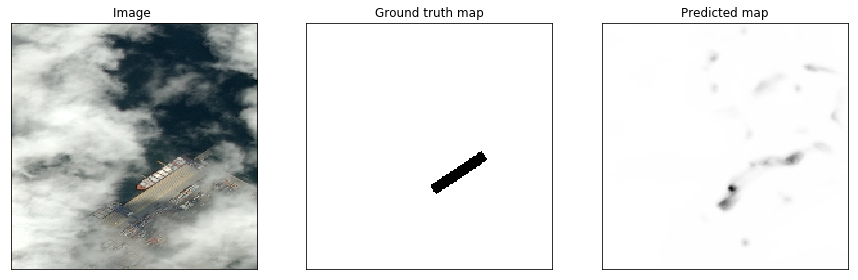

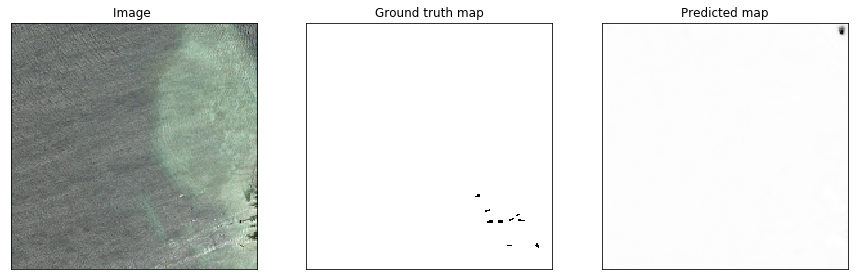

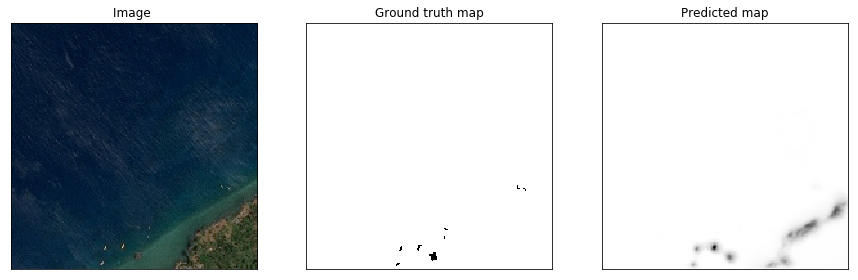

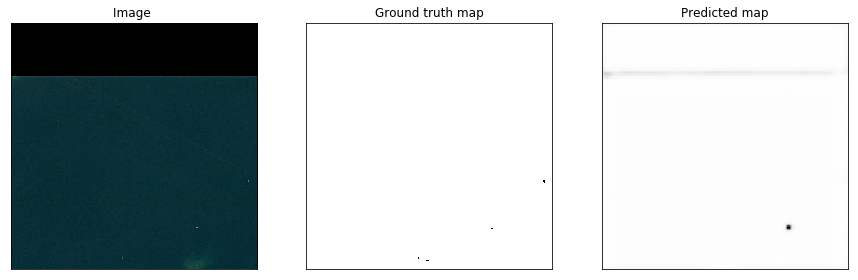

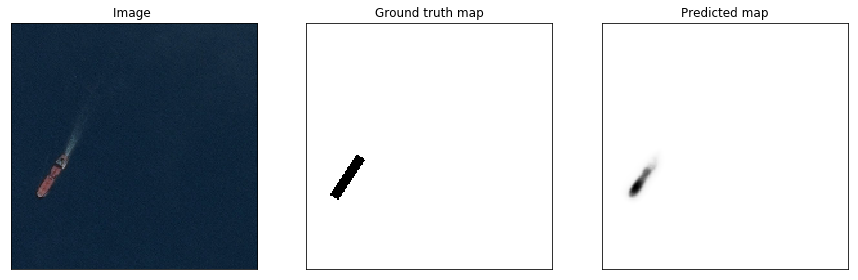

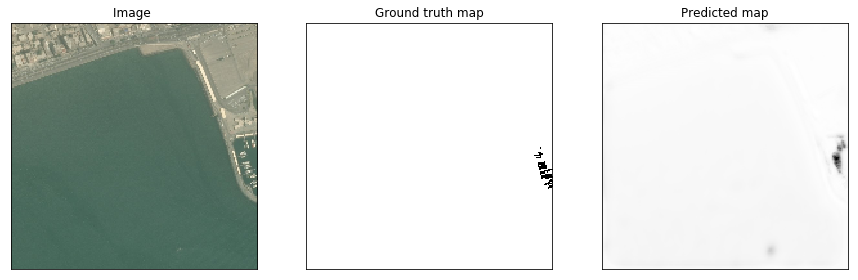

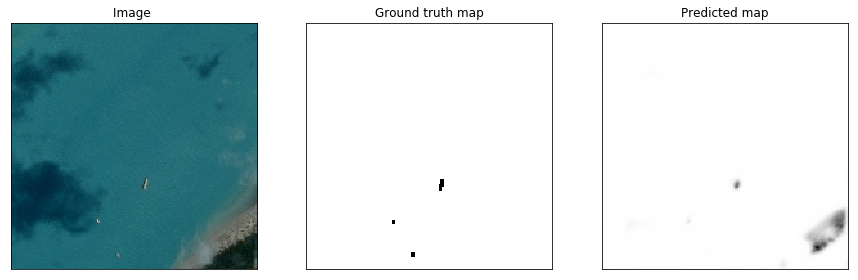

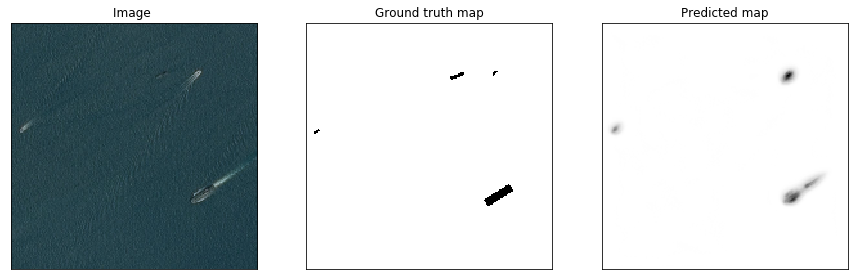

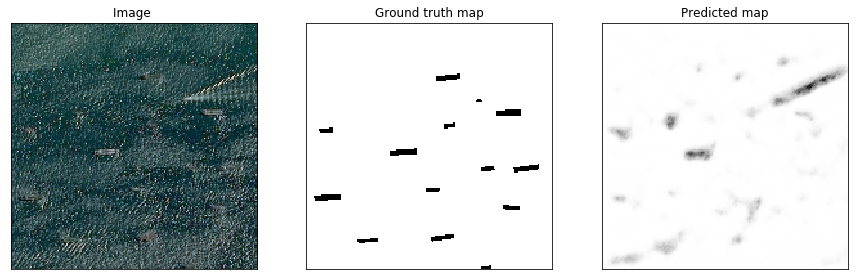

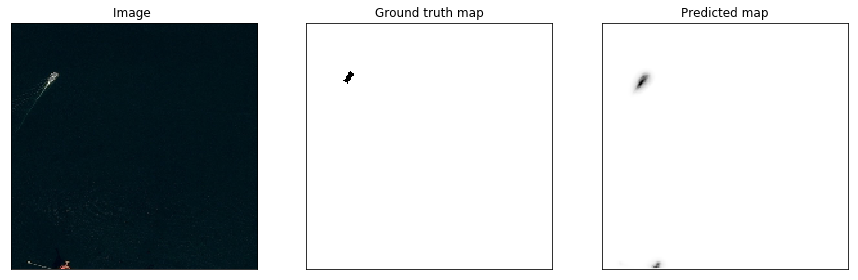

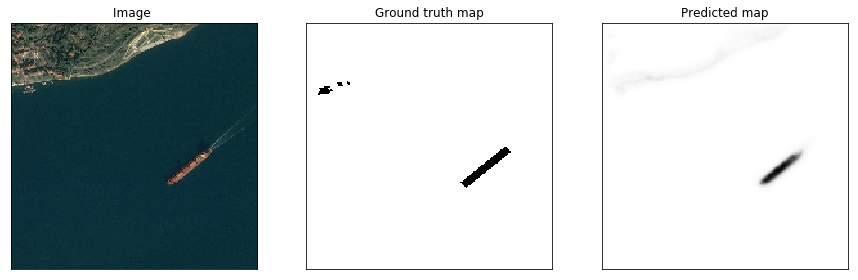

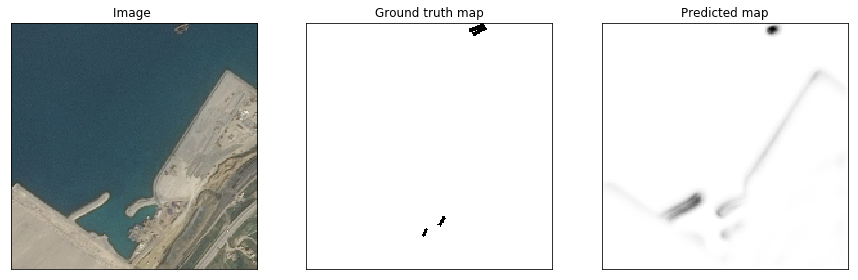

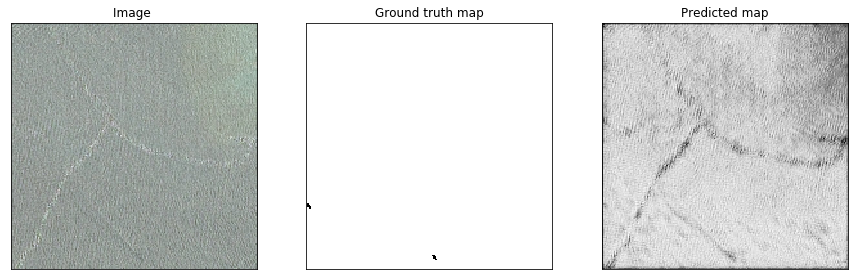

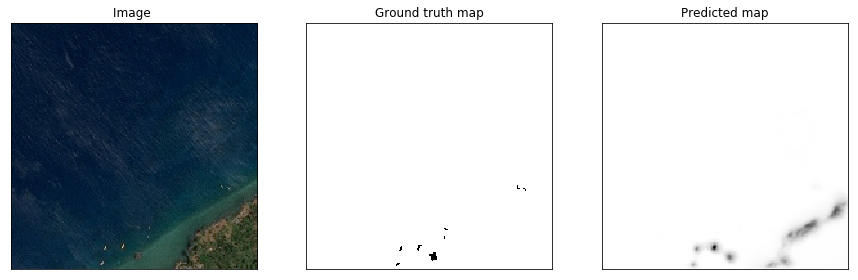

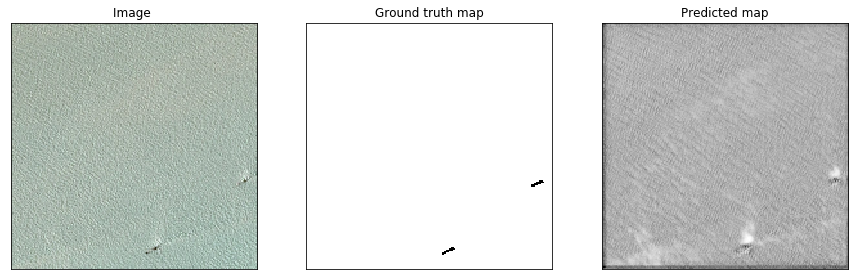

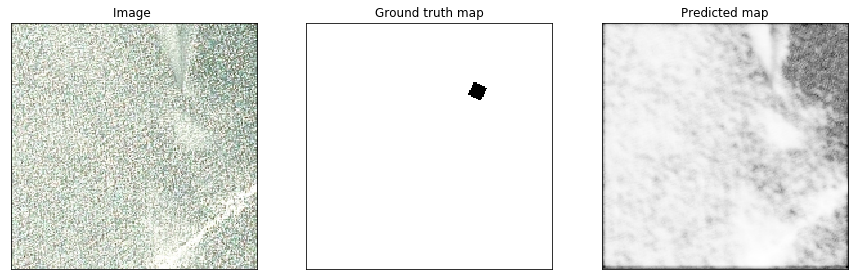

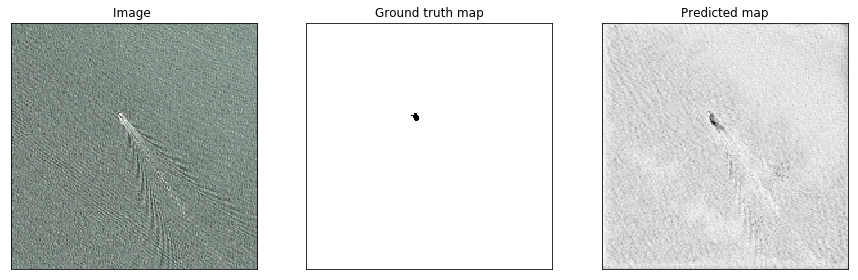

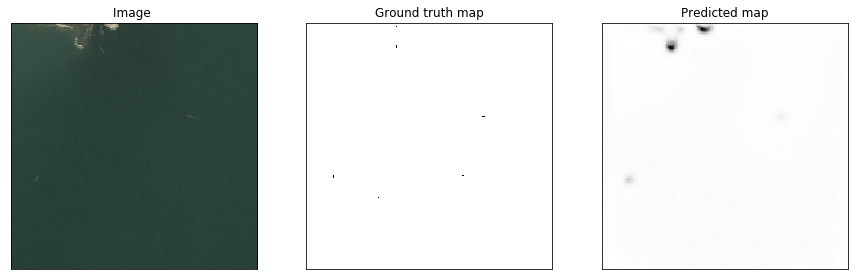

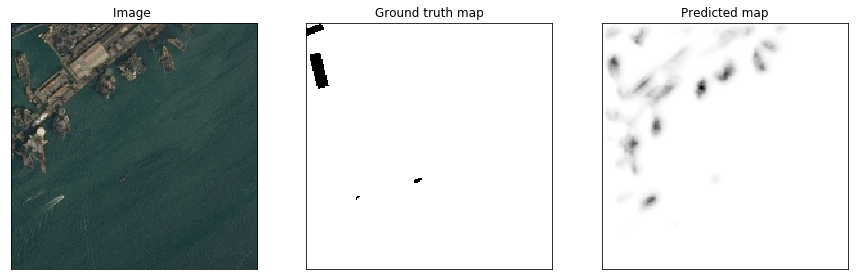

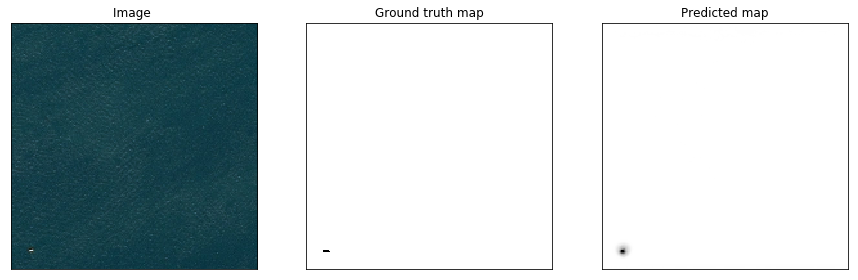

In [19]:
print(predictions.shape)
for i in range(20):
    disp_image_with_map2(test_images[i], test_mask_true[i], predictions[i])

Normalized confusion matrix
[[9.99986261e-01 1.37391851e-05]
 [9.52029865e-01 4.79701353e-02]]


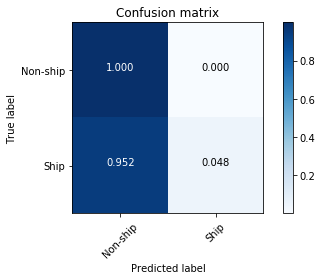

In [16]:
from sklearn.metrics import confusion_matrix
threshold = 0.5
predictions = (predictions>threshold).astype(int)

conf = confusion_matrix(test_mask_true.flatten(),predictions.flatten())
plot_confusion_matrix(conf,classes=["Non-ship", "Ship"], normalize=True);

In [17]:
from sklearn.metrics import jaccard_similarity_score, f1_score, balanced_accuracy_score

jaccard = jaccard_similarity_score(test_mask_true.flatten(),predictions.flatten())
balanced = balanced_accuracy_score(test_mask_true.flatten(),predictions.flatten())
f1 = f1_score(test_mask_true.flatten(),predictions.flatten())
print("Jaccard similarity score: ", jaccard)
print("Balanced accuracy score:", balanced)
print("F1 similarity score: ", f1)

Jaccard similarity score:  0.9933977883959574
Balanced accuracy score: 0.5239781980696228
F1 similarity score:  0.09137676248041689
